In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 11.5 MB/s 
     |████████████████████████████████| 46 kB 4.0 MB/s 
     |████████████████████████████████| 189 kB 52.3 MB/s 
     |████████████████████████████████| 1.2 MB 38.7 MB/s 
     |████████████████████████████████| 56 kB 4.2 MB/s 
     |████████████████████████████████| 51 kB 297 kB/s 
Mounted at /content/gdrive


In [2]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)

In [4]:
Path.BASE_PATH = path

In [5]:
path.ls()

(#3) [Path('valid'),Path('train'),Path('labels.csv')]

In [6]:
(path/'train').ls()

(#2) [Path('train/7'),Path('train/3')]

In [7]:
(path/'valid').ls()

(#2) [Path('valid/7'),Path('valid/3')]

In [8]:
(path/'train/3').ls()

(#6131) [Path('train/3/10765.png'),Path('train/3/17010.png'),Path('train/3/35944.png'),Path('train/3/47979.png'),Path('train/3/29289.png'),Path('train/3/43702.png'),Path('train/3/42441.png'),Path('train/3/28406.png'),Path('train/3/21673.png'),Path('train/3/12218.png')...]

(<matplotlib.axes._subplots.AxesSubplot at 0x7f9d3ed5ee90>, torch.Tensor)

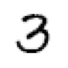

In [9]:
# take a 3 to test manually applying kernels as well as using functional pytorch to apply kernels
test_3 = tensor(Image.open(path/'train/3/49020.png'))
show_image(test_3), type(test_3)

## Apply a single kernel to an image and show the results
- Use raw python to apply a single kernel for creating convolutions
- Test 2 kernels on an image 

In [10]:
top_kernel_1 = tensor([[-1, -1, -1], [0, 0, 0], [1, 1, 1]]).float()
top_kernel_1

tensor([[-1., -1., -1.],
        [ 0.,  0.,  0.],
        [ 1.,  1.,  1.]])

In [11]:
top_kernel_2 = tensor([[-1, -1, -1], [1, 1, 1], [0, 0, 0]]).float()
top_kernel_2

tensor([[-1., -1., -1.],
        [ 1.,  1.,  1.],
        [ 0.,  0.,  0.]])

In [12]:
def apply_kernel(image_tens, row, col, kernel):
  """
  Apply a kernel to a certain location of an image tensor
  """
  ks = kernel.shape[0]
  half_ks = ks//2
  # use row, col as the centre of the image to apply the kernel
  kernel_comp = (image_tens[row-half_ks:row+half_ks+1, col-half_ks:col+half_ks+1] * kernel).sum()
  return kernel_comp

In [13]:
# test the apply kernel function on the top left part of the image
apply_kernel(test_3, 1, 1, top_kernel_1)

tensor(0.)

In [14]:
test_3.shape

torch.Size([28, 28])

In [15]:
apply_kernel(test_3, 15, 15, top_kernel_1)

tensor(-287.)

In [16]:
apply_kernel(test_3, 3, 15, top_kernel_1)

tensor(438.)

In [17]:
apply_kernel(test_3, 4, 15, top_kernel_1)

tensor(756.)

In [18]:
apply_kernel(test_3, 5, 15, top_kernel_2)

tensor(318.)

In [19]:
def apply_convolution(image_tens, kernel):
  """
  Apply a kernel to the entire grid space
  """
  half_ks = kernel.shape[0]//2
  min_dim = half_ks
  max_dim = image_tens.shape[0] - half_ks

  conv = tensor([[apply_kernel(test_3, row, col, kernel) for col in range(min_dim, max_dim)] for row in range(min_dim, max_dim)])
  return conv
  

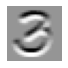

In [20]:
show_image(apply_convolution(test_3, top_kernel_1))

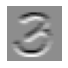

In [21]:
show_image(apply_convolution(test_3, top_kernel_2))

## Apply multiple kernels at a time
- Use pytorch functional to apply multiple convolutions with 4 different kernels

In [22]:
diag1_edge = tensor([[ 0,-1, 1],
                     [-1, 1, 0],
                     [ 1, 0, 0]]).float()
diag2_edge = tensor([[ 1,-1, 0],
                     [ 0, 1,-1],
                     [ 0, 0, 1]]).float()

cross_kernel = tensor([[1, 1, 1], 
                       [0, 0, 1], 
                       [-3, 0, 1]])


In [23]:
all_kernels = torch.stack([top_kernel_1, diag1_edge, diag2_edge, cross_kernel], axis=0)
all_kernels.shape

torch.Size([4, 3, 3])

In [24]:
# load in a batch to test torch functional conv2d
mnist = DataBlock((ImageBlock(cls=PILImageBW), CategoryBlock), 
                  get_items=get_image_files, 
                  splitter=GrandparentSplitter(),
                  get_y=parent_label)

dls = mnist.dataloaders(path)
xb,yb = first(dls.train)
xb.shape

torch.Size([64, 1, 28, 28])

In [25]:
# reshape the weights. Only have a single input channel so (4, 1, 3, 3)
all_kernels.unsqueeze_(axis=1)
all_kernels.shape

torch.Size([4, 1, 3, 3])

In [26]:
all_kernels = all_kernels.cuda()

In [27]:
res = F.conv2d(xb, all_kernels)
res.shape

torch.Size([64, 4, 26, 26])

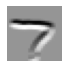

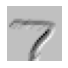

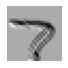

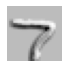

In [28]:
# look at the 4 output channels on the first image
for i in range(4):
  show_image(res[0, i])

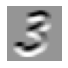

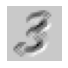

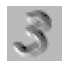

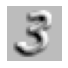

In [29]:
for i in range(4):
  show_image(res[2, i])

## Create a basic CNN using pytorch

In [34]:
# create a convolutional function to return a sequential layer given number of input and out channels desired

def stride_2_conv(in_ch, out_ch, ks=3, output=False):
  """
  Apply a stride 2 conv given a number of input channels and output channels
  """
  conv_layer = nn.Conv2d(in_ch, out_ch, ks, stride=2, padding=ks//2)
  if not output:
    conv_layer = nn.Sequential(
        conv_layer,
        nn.ReLU()
    )
  
  return conv_layer

In [50]:
# basic cnn as implemented in the book
basic_cnn = nn.Sequential(
    stride_2_conv(1, 4), # 14x14
    stride_2_conv(4, 8), # 7x7
    stride_2_conv(8, 16), # 4x4
    stride_2_conv(16, 32), # 2x2
    stride_2_conv(32, 2, output=True), # 1x1
    nn.Flatten()
)

In [51]:
basic_cnn_2 = nn.Sequential(
    stride_2_conv(1, 2), # 14x14,
    stride_2_conv(2, 4), # 7x7
    stride_2_conv(4, 8), # 4x4
    stride_2_conv(8, 16), # 2x2
    stride_2_conv(16, 2, output=True), # 1x1
    nn.Flatten()
)

In [35]:
# assume inputs are of shape bs x in_ch x im_wid x im_height

simple_cnn = nn.Sequential(
    stride_2_conv(1, 4), # 14x14
    # avoid going from 9 (ks=3) -> 8 activaitons by using ks=5
    stride_2_conv(4, 8, ks=5), # 7x7
    stride_2_conv(8, 16), # 4x4
    stride_2_conv(16, 32), # 2x2
    stride_2_conv(32, 2, output=True), # 1x1
    nn.Flatten()
)

In [36]:
# try keeping activation size the same as we go through the network
# computation increases by a factor of 8 moving from layer to layer in the network 
experimental_cnn = nn.Sequential(
    # keep activation size the same by going from 1->4 channels since we reduce the activation image size by 4
    stride_2_conv(1, 4), # 14x14
    # this next layer is not problematic since we are going from 9 pixels to 16 activations (rather than 9 -> 8 as in previous network)
    stride_2_conv(4, 16), # 7x7
    stride_2_conv(16, 64), # 4x4
    stride_2_conv(64, 256), # 2x2
    stride_2_conv(256, 2, output=True), # 1x1
    nn.Flatten()
)

In [43]:
# try keeping computation equivalent throughtout the network

experimental_cnn_2 = nn.Sequential(
    # keep activation size the same by going from 1->4 channels since we reduce the activation image size by 4
    stride_2_conv(1, 4), # 14x14
    # this next layer is not problematic since we are going from 9 pixels to 16 activations (rather than 9 -> 8 as in previous network)
    # note that computation has now increased by a factor of 16 but will remain constant after this point
    stride_2_conv(4, 16), # 7x7
    stride_2_conv(16, 32), # 4x4
    stride_2_conv(32, 64), # 2x2
    stride_2_conv(64, 2, output=True), # 1x1
    nn.Flatten()
)

SuggestedLRs(valley=0.002511886414140463)

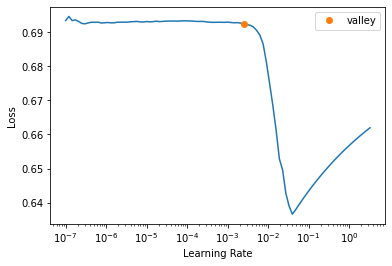

In [38]:
# train the simple cnn on 3s vs 7s
learn = Learner(dls, simple_cnn, loss_func=CrossEntropyLossFlat(), metrics=[accuracy])
learn.lr_find()

In [39]:
learn.fit_one_cycle(2, 2e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.392312,0.384842,0.974975,00:16
1,0.369007,0.369899,0.985770,00:16


SuggestedLRs(valley=0.0006918309954926372)

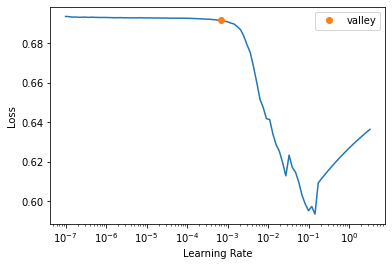

In [41]:
# train 3s vs 7s on the expiermental cnn
learn_2 = Learner(dls, experimental_cnn, loss_func=CrossEntropyLossFlat(), metrics=[accuracy])
learn_2.lr_find()

In [42]:
learn_2.fit_one_cycle(3, 4e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.431560,0.389885,0.495584,00:16
1,0.374758,0.375054,0.495584,00:16
2,0.368609,0.372639,0.495584,00:16


SuggestedLRs(valley=0.002511886414140463)

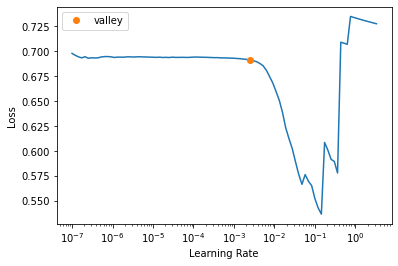

In [44]:
learn_3 = Learner(dls, experimental_cnn_2, loss_func=CrossEntropyLossFlat(), metrics=[accuracy])
learn_3.lr_find()

In [45]:
learn_3.fit_one_cycle(3, 2e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.111247,0.062303,0.977920,00:17
1,0.041180,0.052477,0.982336,00:17
2,0.029283,0.040180,0.986752,00:17


In [52]:
learn_basic = Learner(dls, basic_cnn, loss_func=CrossEntropyLossFlat(), metrics=[accuracy])
learn_basic_2 = Learner(dls, basic_cnn_2, loss_func=CrossEntropyLossFlat(), metrics=[accuracy])

In [53]:
learn_basic.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.177679,0.096225,0.965162,00:16
1,0.054708,0.066250,0.977920,00:16
2,0.046893,0.064186,0.980864,00:16


In [54]:
learn_basic_2.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.274704,0.117052,0.955839,00:16
1,0.082758,0.086360,0.969087,00:16
2,0.065606,0.075761,0.972031,00:16


## Findings from simple mnist experimentation
- In the CNN, keeping the amount of computation the same is more relevant than keeping the number of activations between layers the same (number of activations can drop off if computation remains the same)

## Full MNIST
- Load in the full mnist dataset with digits ranging from 0 to 9
- 